# Nobel Prize Analysis

## Setup and Context

### Introduction

On November 27, 1895, Alfred Nobel signed his last will in Paris. When it was opened after his death, the will caused a lot of controversy, as Nobel had left much of his wealth for the establishment of a prize.

Alfred Nobel dictates that his entire remaining estate should be used to endow “prizes to those who, during the preceding year, have conferred the greatest benefit to humankind”.

Every year the Nobel Prize is given to scientists and scholars in the categories chemistry, literature, physics, physiology or medicine, economics, and peace. 

<img src=https://i.imgur.com/36pCx5Q.jpg>

Let's see what patterns we can find in the data of the past Nobel laureates. What can we learn about the Nobel prize and our world more generally?

### Upgrade plotly (only Google Colab Notebook)

Google Colab may not be running the latest version of plotly. If you're working in Google Colab, uncomment the line below, run the cell, and restart your notebook server. 

In [2]:
# %pip install --upgrade plotly

### Import Statements

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

### Notebook Presentation

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

### Read the Data

In [5]:
df_data = pd.read_csv('nobel_prize_data.csv')

Caveats: The exact birth dates for Michael Houghton, Venkatraman Ramakrishnan, and Nadia Murad are unknown. I've substituted them with mid-year estimate of July 2nd. 


## Data Exploration & Cleaning

**Challenge**: Preliminary data exploration. 
* What is the shape of `df_data`? How many rows and columns?
* What are the column names?
* In which year was the Nobel prize first awarded?
* Which year is the latest year included in the dataset?

In [6]:
df_data.shape

(962, 16)

In [7]:
df_data.columns

Index(['year', 'category', 'prize', 'motivation', 'prize_share',
       'laureate_type', 'full_name', 'birth_date', 'birth_city',
       'birth_country', 'birth_country_current', 'sex', 'organization_name',
       'organization_city', 'organization_country', 'ISO'],
      dtype='object')

In [8]:
df_data.head()

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Netherlands,Male,Berlin University,Berlin,Germany,NLD
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,Individual,Sully Prudhomme,1839-03-16,Paris,France,France,Male,NaN,NaN,NaN,FRA
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Poland,Male,Marburg University,Marburg,Germany,POL
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Frédéric Passy,1822-05-20,Paris,France,France,Male,NaN,NaN,NaN,FRA
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Switzerland,Male,NaN,NaN,NaN,CHE


In [9]:
df_data["year"].min()

1901

In [10]:
df_data["year"].max()

2020

**Challange**: 
* Are there any duplicate values in the dataset?
* Are there NaN values in the dataset?
* Which columns tend to have NaN values?
* How many NaN values are there per column? 
* Why do these columns have NaN values?  

### Check for Duplicates

In [11]:
df_data.duplicated().values.any()

False

### Check for NaN Values

In [12]:
df_data.isna().values.any()

True

In [13]:
df_data.isna().sum()

year                       0
category                   0
prize                      0
motivation                88
prize_share                0
laureate_type              0
full_name                  0
birth_date                28
birth_city                31
birth_country             28
birth_country_current     28
sex                       28
organization_name        255
organization_city        255
organization_country     254
ISO                       28
dtype: int64

### Type Conversions

**Challenge**: 
* Convert the `birth_date` column to Pandas `Datetime` objects
* Add a Column called `share_pct` which has the laureates' share as a percentage in the form of a floating-point number.

#### Convert Year and Birth Date to Datetime

In [14]:
df_data["birth_date"] = pd.to_datetime(df_data["birth_date"])

type(df_data["birth_date"][0])

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
df_data.birth_date[0]

Timestamp('1852-08-30 00:00:00')

#### Add a Column with the Prize Share as a Percentage

Adding a column that contains the percentage share as first requires that we split the string on the forward slash. Then we can convert to a number. And finally, we can do the division.

In [16]:
separated_values = df_data["prize_share"].str.split('/', expand=True)
numerator = pd.to_numeric(separated_values[0])
denomenator = pd.to_numeric(separated_values[1])
df_data['share_pct'] = numerator / denomenator

In [17]:
df_data["share_pct"].sample(5)

7     1.00
773   0.50
775   1.00
236   0.25
259   0.50
Name: share_pct, dtype: float64

In [18]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   year                   962 non-null    int64         
 1   category               962 non-null    object        
 2   prize                  962 non-null    object        
 3   motivation             874 non-null    object        
 4   prize_share            962 non-null    object        
 5   laureate_type          962 non-null    object        
 6   full_name              962 non-null    object        
 7   birth_date             934 non-null    datetime64[ns]
 8   birth_city             931 non-null    object        
 9   birth_country          934 non-null    object        
 10  birth_country_current  934 non-null    object        
 11  sex                    934 non-null    object        
 12  organization_name      707 non-null    object        
 13  organ

## Plotly Donut Chart: Percentage of Male vs. Female Laureates

**Challenge**: Create a [donut chart using plotly](https://plotly.com/python/pie-charts/) which shows how many prizes went to men compared to how many prizes went to women. What percentage of all the prizes went to women?

In [19]:
gender = df_data["sex"].value_counts()

fig = px.pie(labels=gender.index.values, values=gender.values, title="Percentage of Male vs. Female Winners", names=gender.index, hole=0.4)

fig.show()

## Who were the first 3 Women to Win the Nobel Prize?

**Challenge**: 
* What are the names of the first 3 female Nobel laureates? 
* What did they win the prize for? 
* What do you see in their `birth_country`? Were they part of an organisation?

In [20]:
df_data[df_data["sex"] == "Female"].sort_values("year", ascending=True)[['year', 'category', 'laureate_type', 'full_name']].head(3)

,year,category,laureate_type,full_name
18,1903,Physics,Individual,"Marie Curie, née Sklodowska"
29,1905,Peace,Individual,"Baroness Bertha Sophie Felicita von Suttner, n..."
51,1909,Literature,Individual,Selma Ottilia Lovisa Lagerlöf


## Find the Repeat Winners

**Challenge**: Did some people get a Nobel Prize more than once? If so, who were they? 

In [21]:
repeat_winners = df_data[df_data.duplicated(subset=["full_name", "birth_date", "birth_city", "birth_country"], keep=False)]

col_subset = ['year', 'category', 'laureate_type', 'full_name']
repeat_winners[col_subset]


,year,category,laureate_type,full_name
18,1903,Physics,Individual,"Marie Curie, née Sklodowska"
62,1911,Chemistry,Individual,"Marie Curie, née Sklodowska"
89,1917,Peace,Organization,Comité international de la Croix Rouge (Intern...
215,1944,Peace,Organization,Comité international de la Croix Rouge (Intern...
278,1954,Chemistry,Individual,Linus Carl Pauling
283,1954,Peace,Organization,Office of the United Nations High Commissioner...
297,1956,Physics,Individual,John Bardeen
306,1958,Chemistry,Individual,Frederick Sanger
340,1962,Peace,Individual,Linus Carl Pauling
348,1963,Peace,Organization,Comité international de la Croix Rouge (Intern...


## Number of Prizes per Category

**Challenge**: 
* In how many categories are prizes awarded? 
* Create a plotly bar chart with the number of prizes awarded by category. 
* Use the color scale called `Aggrnyl` to colour the chart, but don't show a color axis.
* Which category has the most number of prizes awarded? 
* Which category has the fewest number of prizes awarded? 

In [22]:
df_data["category"].nunique()

6

In [23]:
categories = df_data["category"].value_counts()
categories

Medicine      222
Physics       216
Chemistry     186
Peace         135
Literature    117
Economics      86
Name: category, dtype: int64

In [24]:
fig = px.bar(categories, x=categories.index.values, y=categories.values, color=categories.values, color_continuous_scale="aggrnyl")

fig.update_layout(coloraxis_showscale=False, xaxis_title='Nobel Prize Category', yaxis_title='Number of Prizes')

fig.show()

**Challenge**: 
* When was the first prize in the field of Economics awarded?
* Who did the prize go to?

In [25]:
df_data[df_data["category"] == "Economics"].sort_values("year")[["year", "full_name", "birth_country", "organization_name"]].head(1)

,year,full_name,birth_country,organization_name
393,1969,Jan Tinbergen,Netherlands,The Netherlands School of Economics


## Male and Female Winners by Category

**Challenge**: Create a [plotly bar chart](https://plotly.com/python/bar-charts/) that shows the split between men and women by category. 
* Hover over the bar chart. How many prizes went to women in Literature compared to Physics?

<img src=https://i.imgur.com/od8TfOp.png width=650>

In [26]:
m_vs_f_categories = df_data.groupby(['category', 'sex'], as_index=False).agg({'prize': pd.Series.count}).sort_values("sex", ascending=False)
m_vs_f_categories

,category,sex,prize
1,Chemistry,Male,179
3,Economics,Male,84
5,Literature,Male,101
7,Medicine,Male,210
9,Peace,Male,90
11,Physics,Male,212
0,Chemistry,Female,7
2,Economics,Female,2
4,Literature,Female,16
6,Medicine,Female,12


In [27]:
fig = px.bar(m_vs_f_categories, x=m_vs_f_categories["category"], y=m_vs_f_categories["prize"], color=m_vs_f_categories["sex"])

fig.update_layout(xaxis_title='Nobel Prize Category', yaxis_title='Number of Prizes')

fig.show()

## Number of Prizes Awarded Over Time


**Challenge**: Are more prizes awarded recently than when the prize was first created? Show the trend in awards visually. 
* Count the number of prizes awarded every year. 
* Create a 5 year rolling average of the number of prizes (Hint: see previous lessons analysing Google Trends).
* Using Matplotlib superimpose the rolling average on a scatter plot.
* Show a tick mark on the x-axis for every 5 years from 1900 to 2020. (Hint: you'll need to use NumPy). 

<img src=https://i.imgur.com/4jqYuWC.png width=650>

* Use the [named colours](https://matplotlib.org/3.1.0/gallery/color/named_colors.html) to draw the data points in `dogerblue` while the rolling average is coloured in `crimson`. 

<img src=https://i.imgur.com/u3RlcJn.png width=350>

* Looking at the chart, did the first and second world wars have an impact on the number of prizes being given out? 
* What could be the reason for the trend in the chart?

In [28]:
prize_per_year = df_data.groupby(by='year').count()["prize"]

prize_per_year

year
1901     6
1902     7
1903     7
1904     6
1905     5
        ..
2016    11
2017    12
2018    13
2019    14
2020    12
Name: prize, Length: 117, dtype: int64

In [29]:
moving_average = prize_per_year.rolling(window=5).mean()

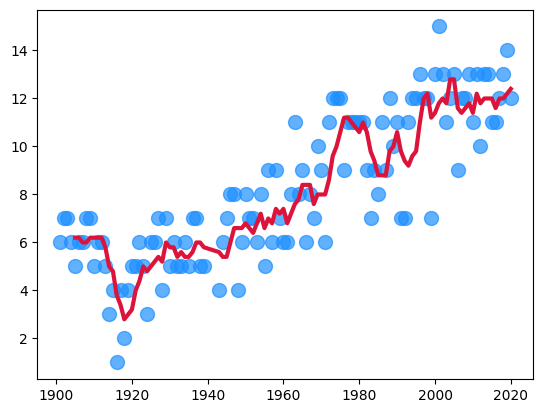

In [30]:
plt.scatter(x=prize_per_year.index, 
           y=prize_per_year.values, 
           c='dodgerblue',
           alpha=0.7,
           s=100,)
 
plt.plot(prize_per_year.index, 
        moving_average.values, 
        c='crimson', 
        linewidth=3,)
 
plt.show()

In [31]:
np.arange(1900, 2021, step=5)

array([1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950,
       1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005,
       2010, 2015, 2020])

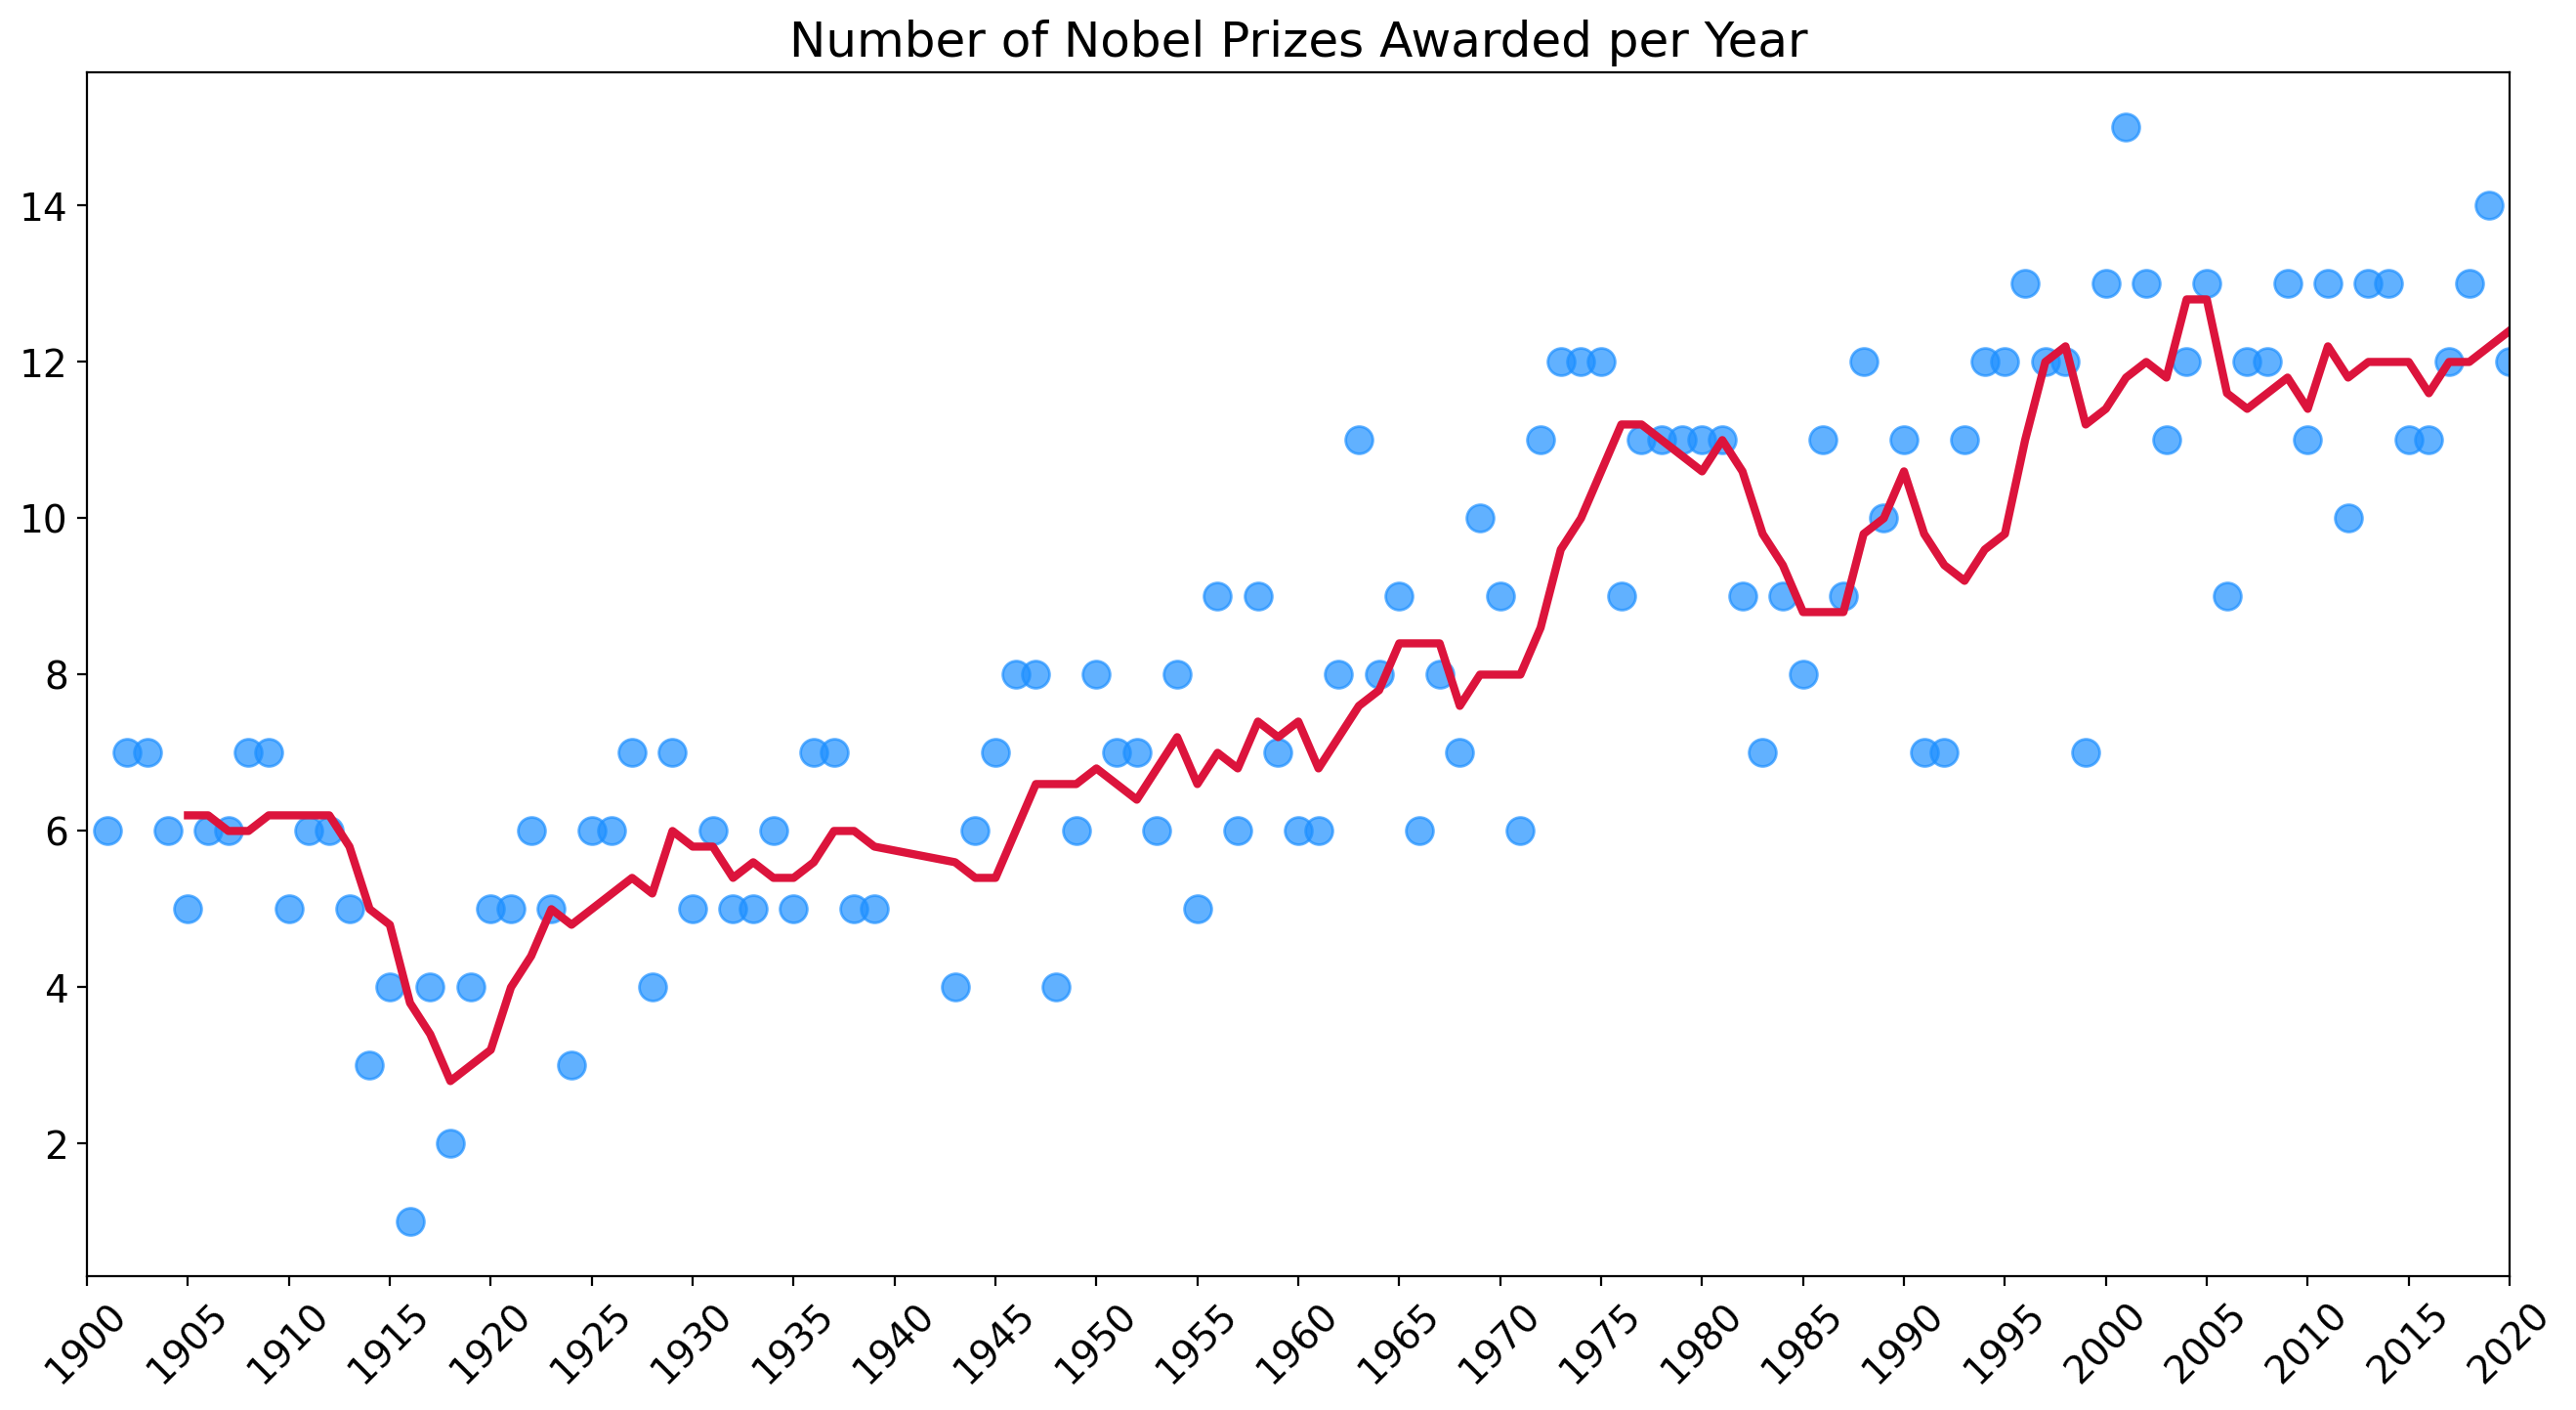

In [32]:
plt.figure(figsize=(16,8), dpi=200)
plt.title('Number of Nobel Prizes Awarded per Year', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(ticks=np.arange(1900, 2021, step=5), 
           fontsize=14, 
           rotation=45)
 
ax1 = plt.gca() # get current axis
ax1.set_xlim(1900, 2020)
 
ax1.scatter(x=prize_per_year.index, 
           y=prize_per_year.values, 
           c='dodgerblue',
           alpha=0.7,
           s=100,)
 
ax1.plot(prize_per_year.index, 
        moving_average.values, 
        c='crimson', 
        linewidth=3,)
 
plt.show()

## Are More Prizes Shared Than Before?

**Challenge**: Investigate if more prizes are shared than before. 

* Calculate the average prize share of the winners on a year by year basis.
* Calculate the 5 year rolling average of the percentage share.
* Copy-paste the cell from the chart you created above.
* Modify the code to add a secondary axis to your Matplotlib chart.
* Plot the rolling average of the prize share on this chart. 
* See if you can invert the secondary y-axis to make the relationship even more clear. 

In [33]:
shares_by_year = df_data.groupby(by="year").mean("share_pct")
shares_by_year

,share_pct
year,
1901,0.83
1902,0.71
1903,0.71
1904,0.83
1905,1.00
...,...
2016,0.55
2017,0.50
2018,0.46


In [34]:
rolling_average = shares_by_year.rolling(window=5).mean()

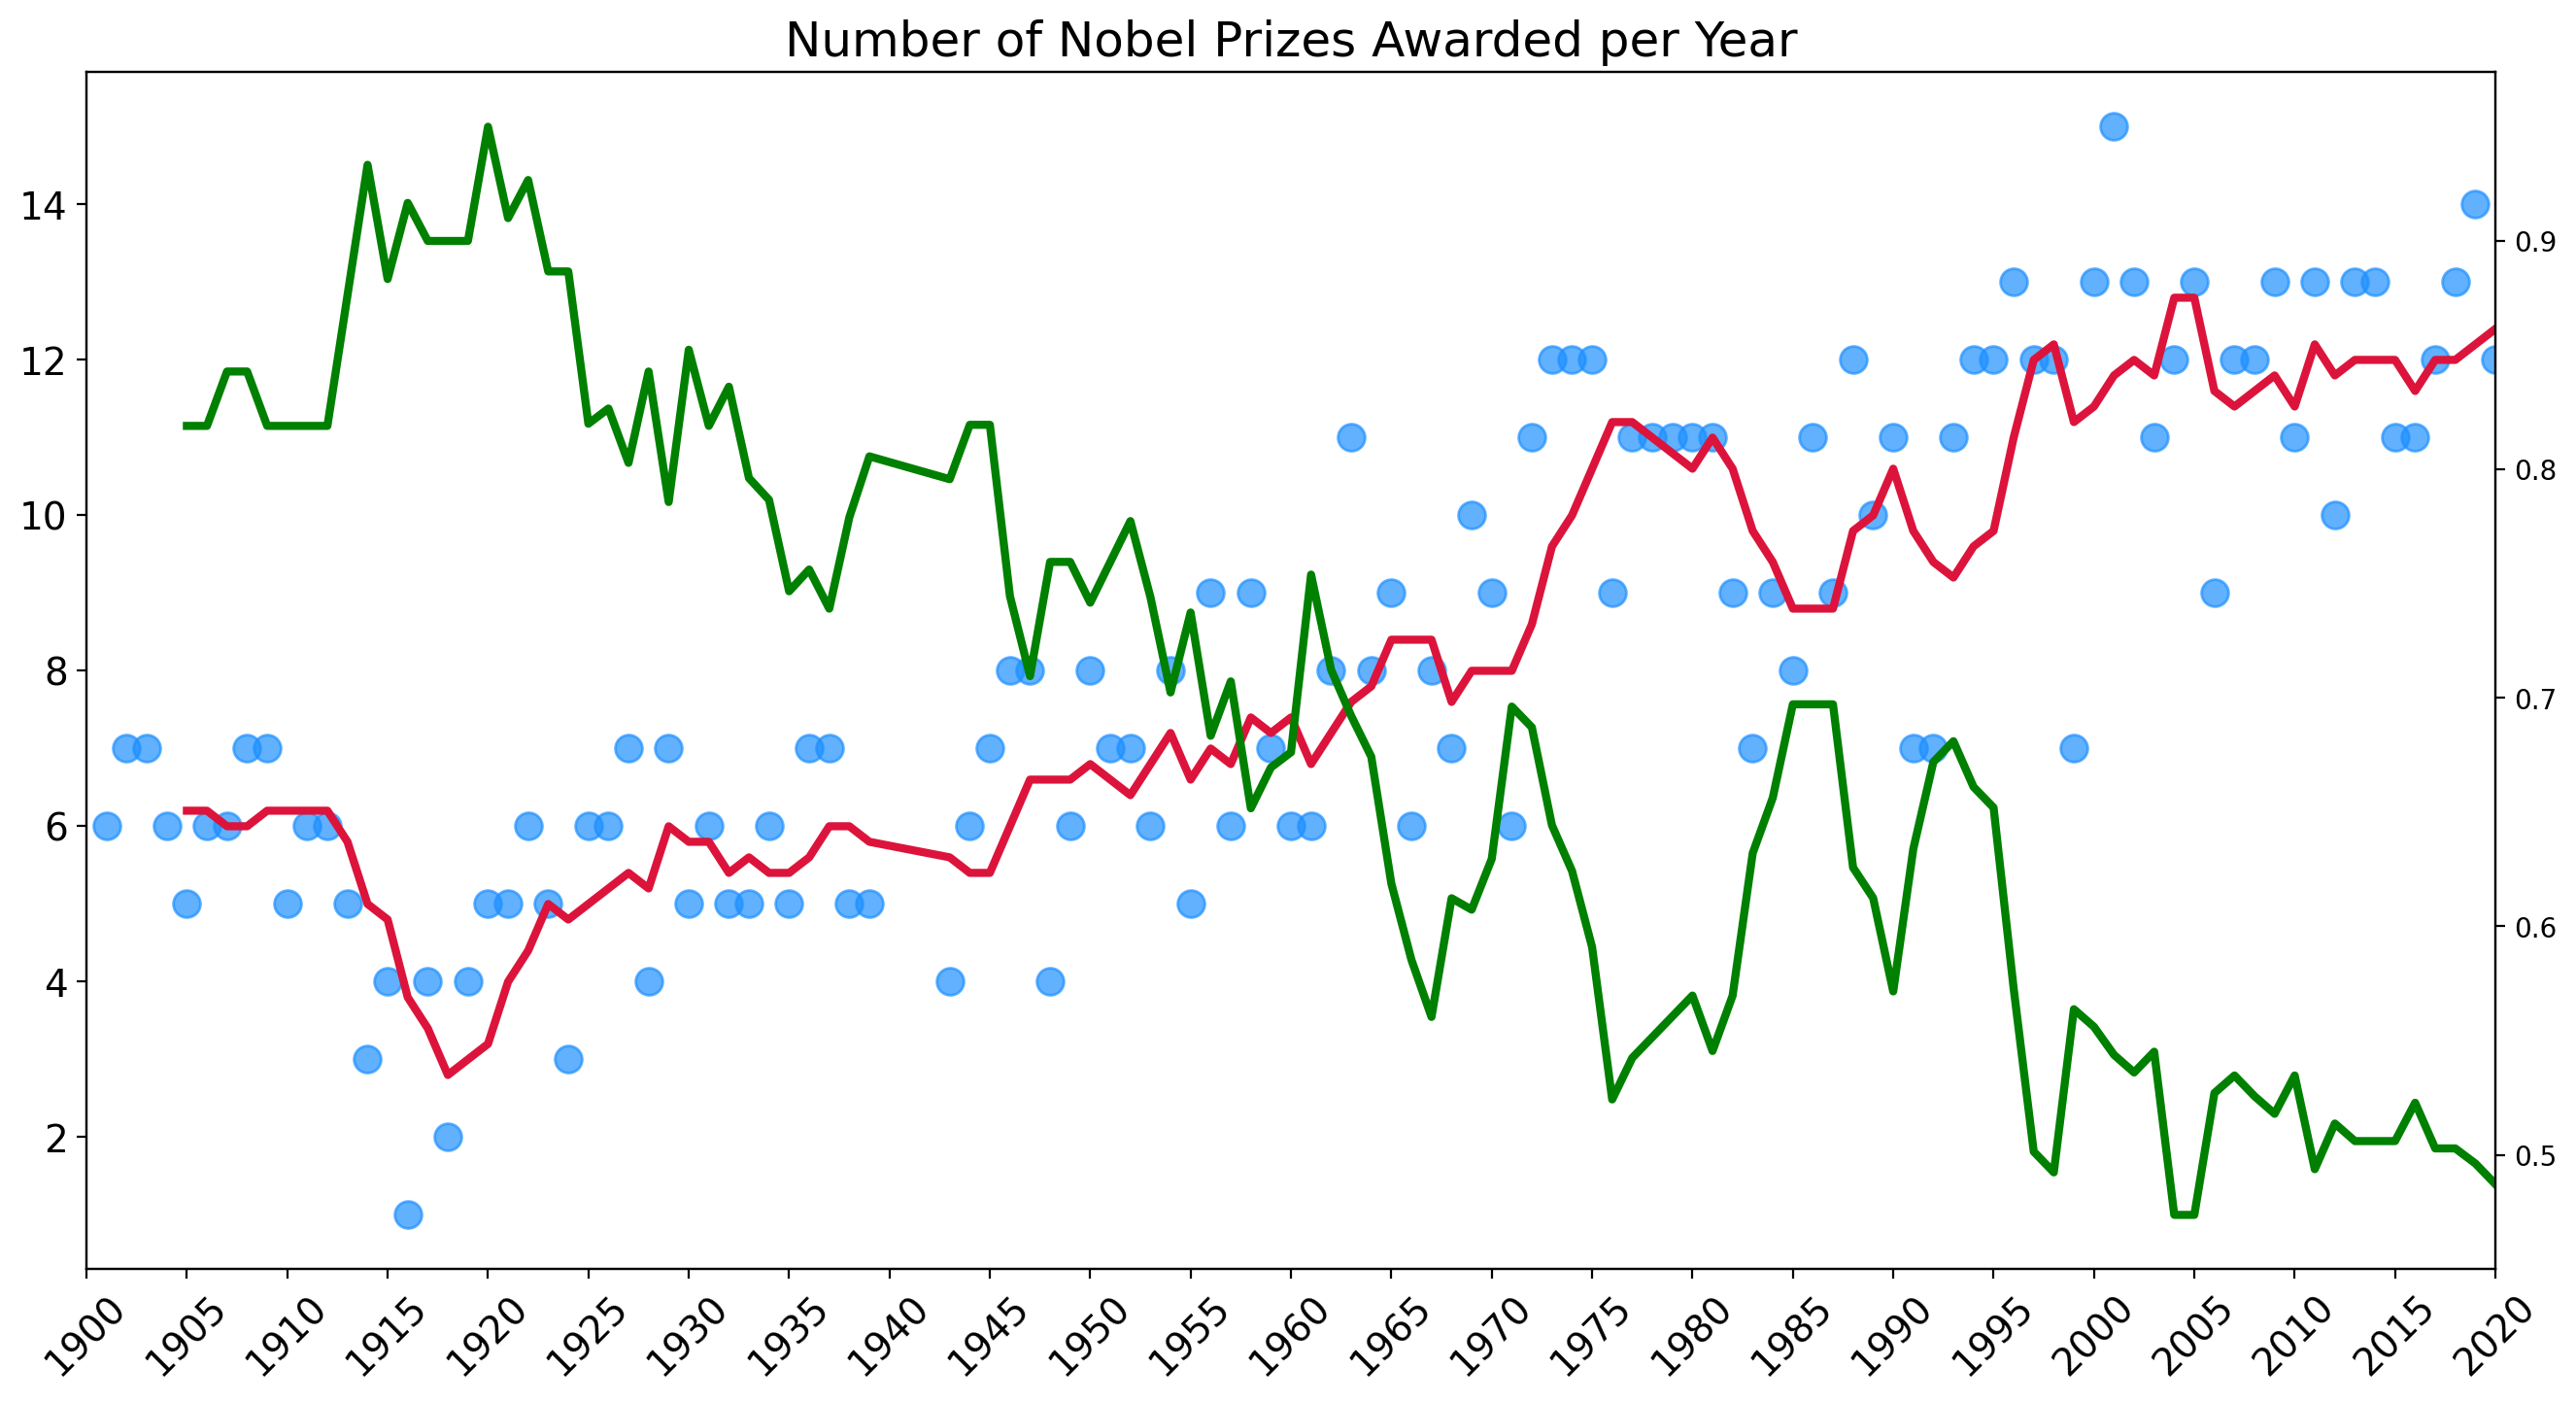

In [35]:
plt.figure(figsize=(16,8), dpi=200)
plt.title('Number of Nobel Prizes Awarded per Year', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(ticks=np.arange(1900, 2021, step=5), 
           fontsize=14, 
           rotation=45)
 
ax1 = plt.gca()
ax2 = ax1.twinx() # create second y-axis
ax1.set_xlim(1900, 2020)
 
ax1.scatter(x=prize_per_year.index, 
           y=prize_per_year.values, 
           c='dodgerblue',
           alpha=0.7,
           s=100,)
 
ax1.plot(prize_per_year.index, 
        moving_average.values, 
        c='crimson', 
        linewidth=3,)
 
# Adding prize share plot on second axis
ax2.plot(prize_per_year.index, 
        rolling_average.values, 
        c='green', 
        linewidth=3,)
 
plt.show()

To see the relationship between the number of prizes and the laureate share even more clearly we can invert the second y-axis.

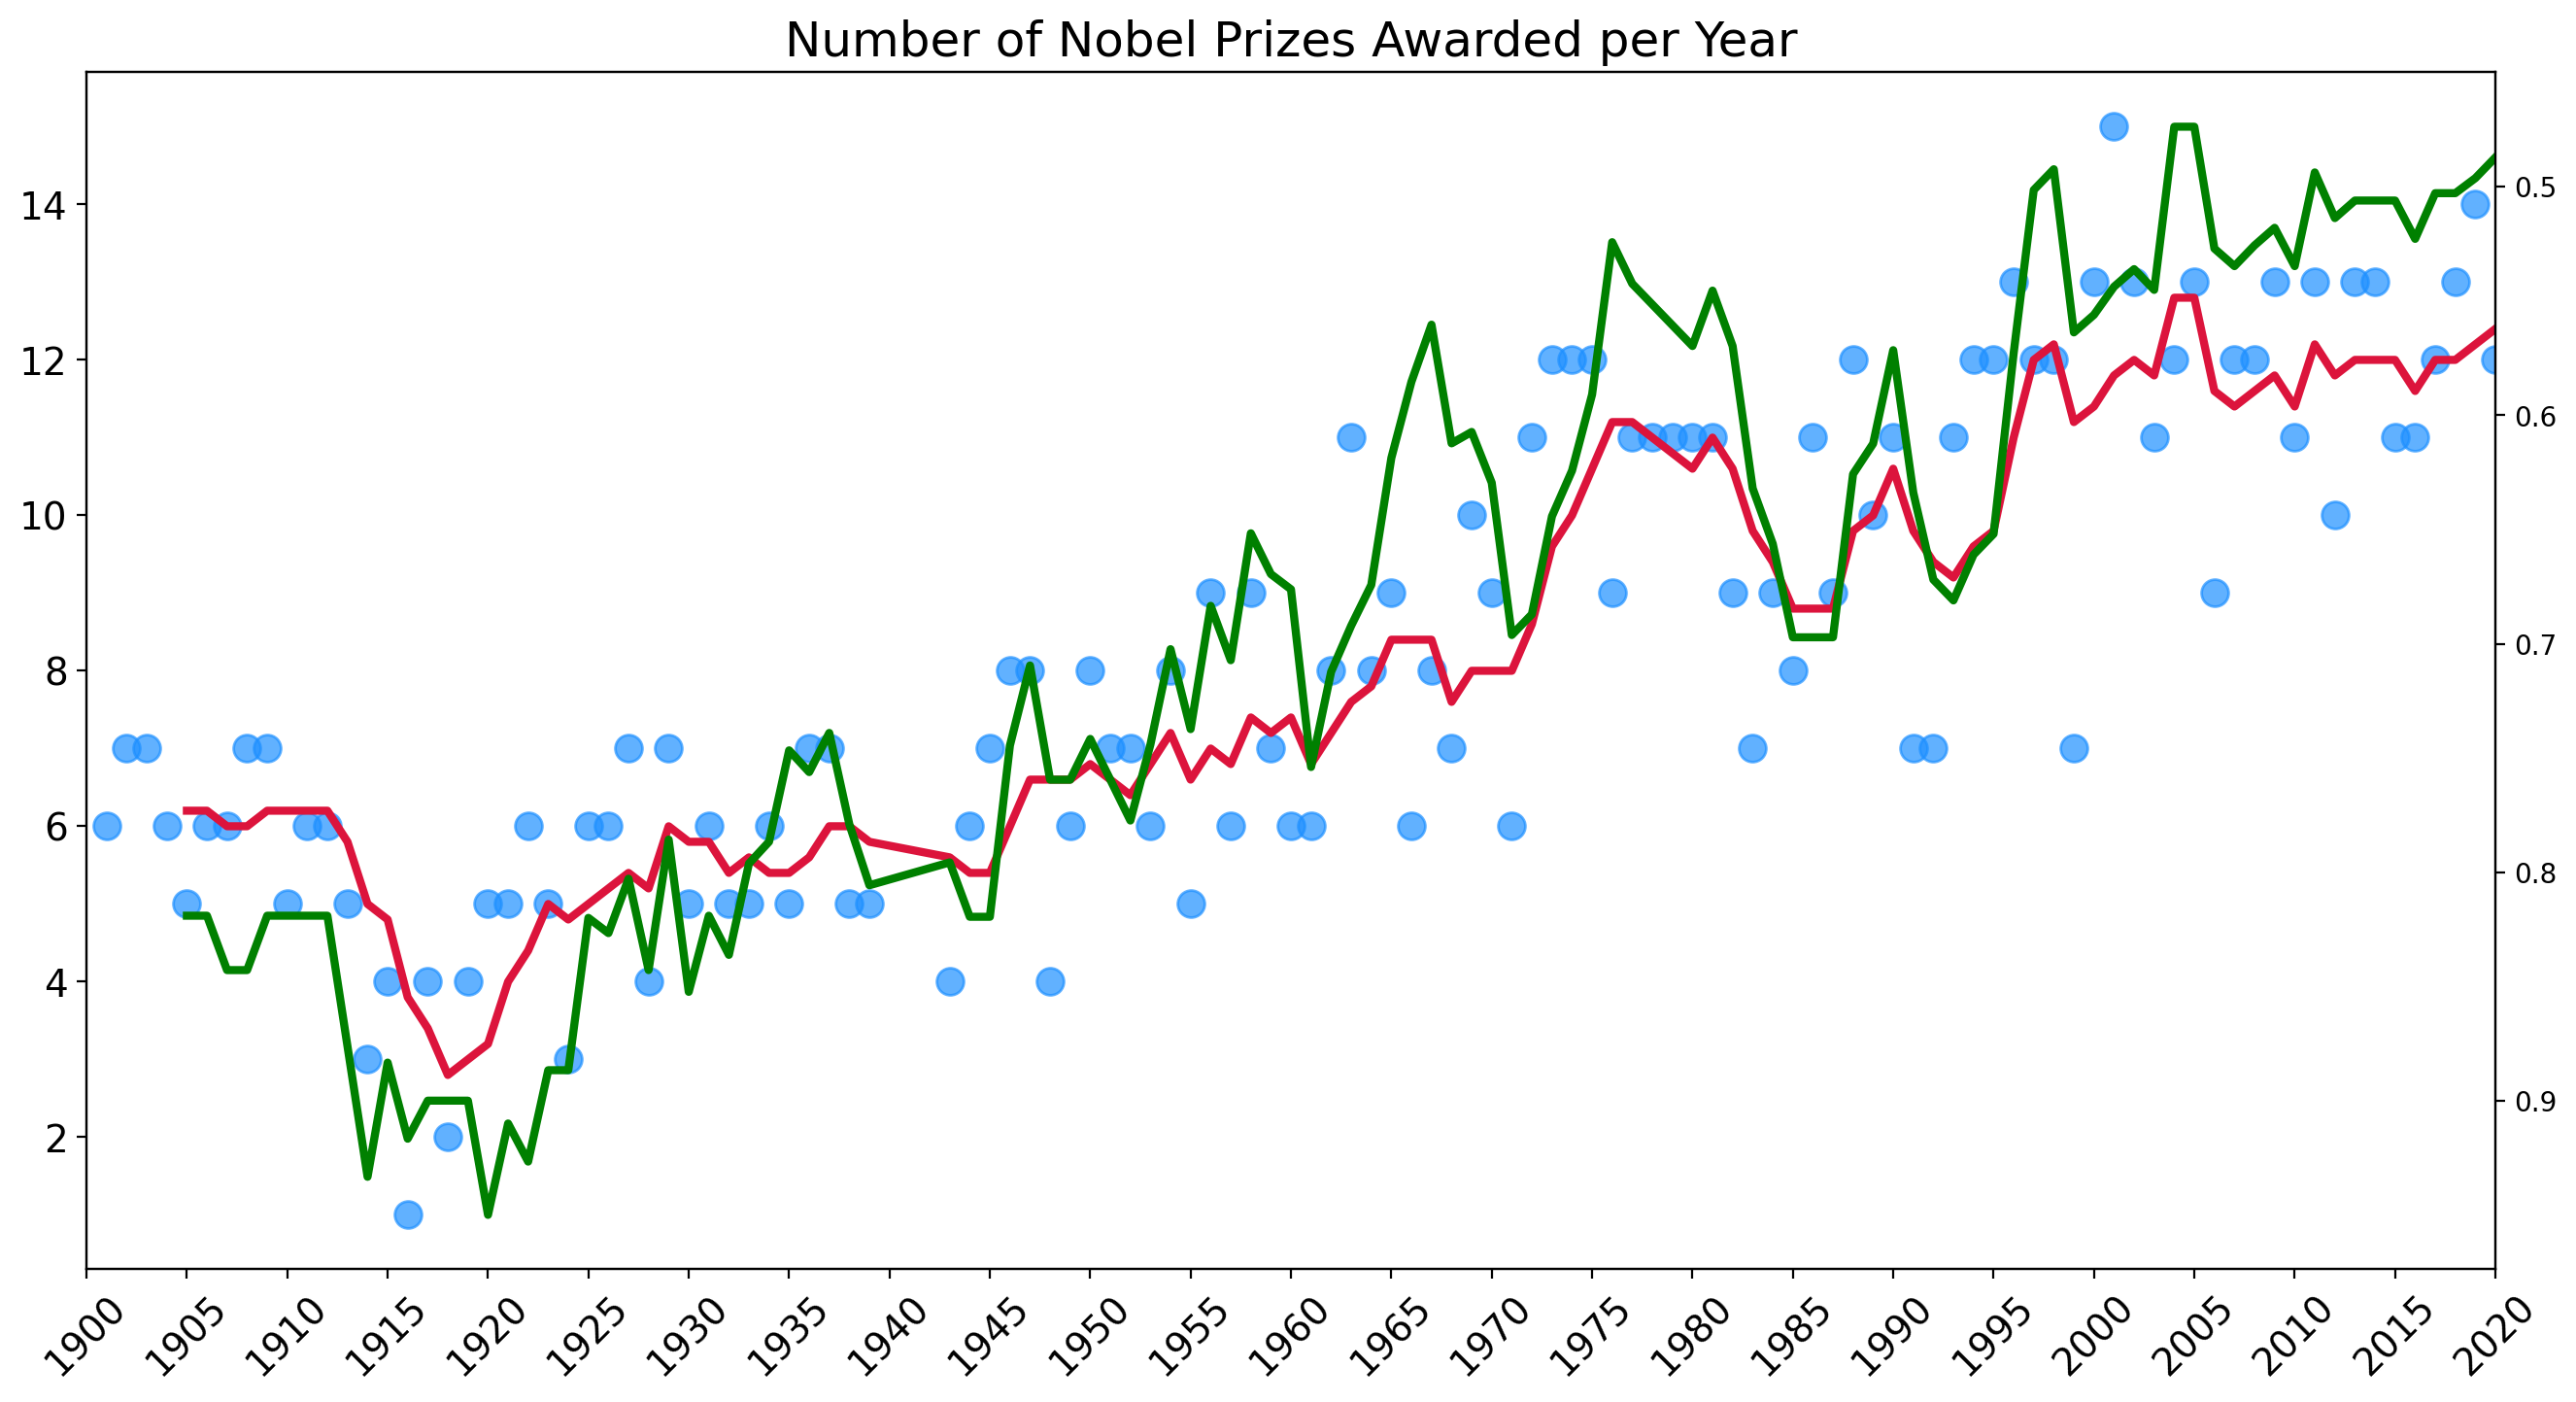

In [36]:
plt.figure(figsize=(16,8), dpi=200)
plt.title('Number of Nobel Prizes Awarded per Year', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(ticks=np.arange(1900, 2021, step=5), 
           fontsize=14, 
           rotation=45)
 
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.set_xlim(1900, 2020)
 
# Can invert axis
ax2.invert_yaxis()
 
ax1.scatter(x=prize_per_year.index, 
           y=prize_per_year.values, 
           c='dodgerblue',
           alpha=0.7,
           s=100,)
 
ax1.plot(prize_per_year.index, 
        moving_average.values, 
        c='crimson', 
        linewidth=3,)
 
ax2.plot(prize_per_year.index, 
        rolling_average.values, 
        c='green', 
        linewidth=3)
 
plt.show()

## The Countries with the Most Nobel Prizes

**Challenge**: 
* Create a Pandas DataFrame called `top20_countries` that has the two columns. The `prize` column should contain the total number of prizes won. 

<img src=https://i.imgur.com/6HM8rfB.png width=350>

* Is it best to use `birth_country`, `birth_country_current` or `organization_country`? 
* What are some potential problems when using `birth_country` or any of the others? Which column is the least problematic? 
* Then use plotly to create a horizontal bar chart showing the number of prizes won by each country. Here's what you're after:

<img src=https://i.imgur.com/agcJdRS.png width=750>

* What is the ranking for the top 20 countries in terms of the number of prizes?

In [37]:
top_20_countries = df_data["birth_country_current"].value_counts().sort_values(ascending=False).head(20)
top_20_countries

United States of America    281
United Kingdom              105
Germany                      84
France                       57
Sweden                       29
Poland                       27
Japan                        27
Russia                       26
Canada                       20
Italy                        19
Switzerland                  19
Austria                      18
Netherlands                  18
Denmark                      12
Norway                       12
China                        12
Australia                    10
South Africa                  9
Belgium                       9
Hungary                       9
Name: birth_country_current, dtype: int64

In [38]:
fig = px.bar(top_20_countries, x=top_20_countries.values, y=top_20_countries.index, orientation='h', color=top_20_countries.values, color_continuous_scale="viridis")

fig.update_layout(coloraxis_showscale=False, xaxis_title='Number of Prizes', yaxis_title='Country')
fig.show()

## Use a Choropleth Map to Show the Number of Prizes Won by Country


* Create this choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/):

<img src=https://i.imgur.com/s4lqYZH.png>

* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map. 

Hint: You'll need to use a 3 letter country code for each country. 

To show the above ranking on a colour coded map, we need to make use of the ISO codes.

In [39]:
df_countries = df_data.groupby(['birth_country_current', 'ISO'], as_index=False).agg({'prize': pd.Series.count})
df_countries.sort_values('prize', ascending=False)

,birth_country_current,ISO,prize
74,United States of America,USA,281
73,United Kingdom,GBR,105
26,Germany,DEU,84
25,France,FRA,57
67,Sweden,SWE,29
...,...,...,...
32,Iceland,ISL,1
47,Madagascar,MDG,1
34,Indonesia,IDN,1
36,Iraq,IRQ,1


This means we can use the ISO country codes for the locations parameter on the choropleth.

In [40]:
world_map = px.choropleth(df_countries,
                          locations='ISO',
                          color='prize', 
                          hover_name='birth_country_current', 
                          color_continuous_scale=px.colors.sequential.matter)
 
world_map.update_layout(coloraxis_showscale=True,)
 
world_map.show()

I love it how plotly allows you to zoom in and pan on the map it generates.

## In Which Categories are the Different Countries Winning Prizes? 


**Challenge**: See if you can divide up the plotly bar chart you created above to show the which categories made up the total number of prizes. Here's what you're aiming for:

<img src=https://i.imgur.com/iGaIKCL.png>

* In which category are Germany and Japan the weakest compared to the United States?
* In which category does Germany have more prizes than the UK?
* In which categories does France have more prizes than Germany?
* Which category makes up most of Australia's nobel prizes?
* Which category makes up half of the prizes in the Netherlands?
* Does the United States have more prizes in Economics than all of France? What about in Physics or Medicine?


The hard part is preparing the data for this chart! 


*Hint*: Take a two-step approach. The first step is grouping the data by country and category. Then you can create a DataFrame that looks something like this:

<img src=https://i.imgur.com/VKjzKa1.png width=450>

In [41]:
cat_country = df_data.groupby(['birth_country_current', 'category'], as_index=False).agg({'prize': pd.Series.count})
cat_country.sort_values(by='prize', ascending=False, inplace=True)

cat_country

,birth_country_current,category,prize
204,United States of America,Medicine,78
206,United States of America,Physics,70
201,United States of America,Chemistry,55
202,United States of America,Economics,49
198,United Kingdom,Medicine,28
...,...,...,...
97,Iraq,Peace,1
99,Ireland,Medicine,1
100,Ireland,Physics,1
102,Israel,Economics,1


Convert the top_20_countries panda series to a dataframe

In [42]:
top_20_countries = pd.DataFrame({'birth_country_current': top_20_countries.index, 'prize': top_20_countries.values})

In [43]:
top_20_countries

,birth_country_current,prize
0,United States of America,281
1,United Kingdom,105
2,Germany,84
3,France,57
4,Sweden,29
5,Poland,27
6,Japan,27
7,Russia,26
8,Canada,20
9,Italy,19


Next, we can merge the DataFrame above with the top20_countries Series that we created previously. That way we get the total number of prizes in a single column too. This is important since we want to control the order for our bar chart.

In [44]:
merged_df = pd.merge(cat_country, top_20_countries, on='birth_country_current')
# change column names
merged_df.columns = ['birth_country_current', 'category', 'cat_prize', 'total_prize'] 
merged_df.sort_values(by='total_prize', inplace=True)

In [45]:
merged_df

,birth_country_current,category,cat_prize,total_prize
91,South Africa,Chemistry,1,9
88,South Africa,Peace,3,9
89,South Africa,Medicine,3,9
90,South Africa,Literature,2,9
101,Hungary,Literature,1,9
...,...,...,...,...
4,United States of America,Peace,19,281
3,United States of America,Economics,49,281
2,United States of America,Chemistry,55,281
1,United States of America,Physics,70,281


Now we can create our bar chart again. This time we use the color parameter based on the category.

In [46]:
cat_cntry_bar = px.bar(x=merged_df["cat_prize"],
                       y=merged_df["birth_country_current"],
                       color=merged_df["category"],
                       orientation='h',
                       title='Top 20 Countries by Number of Prizes and Category')
 
cat_cntry_bar.update_layout(xaxis_title='Number of Prizes', 
                            yaxis_title='Country',
                            height=600)
cat_cntry_bar.show()

### Number of Prizes Won by Each Country Over Time

* When did the United States eclipse every other country in terms of the number of prizes won? 
* Which country or countries were leading previously?
* Calculate the cumulative number of prizes won by each country in every year. Again, use the `birth_country_current` of the winner to calculate this. 
* Create a [plotly line chart](https://plotly.com/python/line-charts/) where each country is a coloured line. 

To see how the prize was awarded over time. To do that, we can count the number of prizes by country by year.

In [148]:
prize_by_year = df_data.groupby(by=['birth_country_current', 'year'], as_index=False).count()
prize_by_year = prize_by_year.sort_values('year')[['year', 'birth_country_current', 'prize']]

Then we can create a series that has the cumulative sum for the number of prizes won.

In [149]:
cumulative_prizes = prize_by_year.groupby(by=['birth_country_current',
                                              'year']).sum().groupby(level=[0]).cumsum()
cumulative_prizes.reset_index(inplace=True) 

Using this, we can create a chart, using the current birth country as the color:

In [150]:
l_chart = px.line(cumulative_prizes,
                  x='year', 
                  y='prize',
                  color='birth_country_current',
                  hover_name='birth_country_current')
 
l_chart.update_layout(xaxis_title='Year',
                      yaxis_title='Number of Prizes')
 
l_chart.show()

## What are the Top Research Organisations?

**Challenge**: Create a bar chart showing the organisations affiliated with the Nobel laureates. It should looks something like this:

<img src=https://i.imgur.com/zZihj2p.png width=600>

* Which organisations make up the top 20?
* How many Nobel prize winners are affiliated with the University of Chicago and Harvard University?

In [47]:
top_20_organizations = df_data.groupby(['organization_name'], as_index=False).agg({'prize': pd.Series.count}).sort_values("prize", ascending=False).head(20)

top_20_organizations

,organization_name,prize
196,University of California,40
68,Harvard University,29
167,Stanford University,23
117,Massachusetts Institute of Technology (MIT),21
198,University of Chicago,20
197,University of Cambridge,18
26,California Institute of Technology (Caltech),17
38,Columbia University,17
146,Princeton University,15
152,Rockefeller University,13


In [51]:
org_bar = px.bar(data_frame=top_20_organizations, 
             orientation="h", 
             x=top_20_organizations["prize"], 
             y=top_20_organizations["organization_name"], 
             title="Top 20 Organizations",
             color=top_20_organizations["prize"],
             color_continuous_scale="haline",
             height=600)

org_bar.update_layout(coloraxis_showscale=False, xaxis_title='Number of Prizes', yaxis_title='Organization Name')

org_bar.show()

## Which Cities Make the Most Discoveries?

Where do major discoveries take place?  

**Challenge**: 
* Create another plotly bar chart graphing the top 20 organisation cities of the research institutions associated with a Nobel laureate. 
* Where is the number one hotspot for discoveries in the world?
* Which city in Europe has had the most discoveries?

In [100]:
df_org_cities = df_data[["organization_city", "prize"]]

top_20_cities = df_org_cities.groupby(["organization_city"], as_index=False).agg({"prize" : pd.Series.count}).sort_values("prize", ascending=False).head(20)

top_20_cities

,organization_city,prize
34,"Cambridge, MA",50
121,"New York, NY",45
33,Cambridge,31
92,London,27
128,Paris,25
156,"Stanford, CA",24
12,"Berkeley, CA",21
39,"Chicago, IL",20
135,"Princeton, NJ",19
129,"Pasadena, CA",17


In [102]:
city_bar = px.bar(data_frame=top_20_cities, 
             orientation="h", 
             x=top_20_cities["prize"], 
             y=top_20_cities["organization_city"], 
             title="Top 20 Cities",
             color=top_20_organizations["prize"],
             color_continuous_scale="plotly3",
             height=600)

city_bar.update_layout(coloraxis_showscale=False, xaxis_title='Number of Prizes', yaxis_title='Organization City')

city_bar.show()

## Where are Nobel Laureates Born? Chart the Laureate Birth Cities 


**Challenge**: 
* Create a plotly bar chart graphing the top 20 birth cities of Nobel laureates. 
* Use a named colour scale called `Plasma` for the chart.
* What percentage of the United States prizes came from Nobel laureates born in New York? 
* How many Nobel laureates were born in London, Paris and Vienna? 
* Out of the top 5 cities, how many are in the United States?

In [107]:
df_birth_cities = df_data[["birth_city", "prize"]]

df_birth_cities = df_birth_cities.groupby(["birth_city"], as_index=False).agg({"prize" : pd.Series.count}).sort_values("prize", ascending=False).head(20)

df_birth_cities

,birth_city,prize
382,"New York, NY",53
418,Paris,26
313,London,19
572,Vienna,14
112,"Chicago, IL",12
48,Berlin,11
590,"Washington, DC",8
76,"Brooklyn, NY",8
80,Budapest,8
64,"Boston, MA",8


In [108]:
city_bar = px.bar(data_frame=df_birth_cities.head(20), 
             orientation="h", 
             x=df_birth_cities["prize"], 
             y=df_birth_cities["birth_city"], 
             title="Top 20 Birth Cities of Noble Prize Laureates",
             color=df_birth_cities["prize"],
             color_continuous_scale="plasma",
             height=600)

city_bar.update_layout(coloraxis_showscale=False, xaxis_title='Number of Prizes', yaxis_title='Birth cities')

city_bar.show()

## Plotly Sunburst Chart: Combine Country, City, and Organisation



**Challenge**: 

* Create a DataFrame that groups the number of prizes by organisation. 
* Then use the [plotly documentation to create a sunburst chart](https://plotly.com/python/sunburst-charts/)
* Click around in your chart, what do you notice about Germany and France? 


Here's what you're aiming for:

<img src=https://i.imgur.com/cemX4m5.png width=300>

In [112]:
country_city_org = df_data.groupby(by=['organization_country', 'organization_city', 'organization_name'], as_index=False).agg({'prize': pd.Series.count})
 
country_city_org = country_city_org.sort_values('prize', ascending=False)

country_city_org

,organization_country,organization_city,organization_name,prize
205,United States of America,"Cambridge, MA",Harvard University,29
280,United States of America,"Stanford, CA",Stanford University,23
206,United States of America,"Cambridge, MA",Massachusetts Institute of Technology (MIT),21
209,United States of America,"Chicago, IL",University of Chicago,20
195,United States of America,"Berkeley, CA",University of California,19
...,...,...,...,...
110,Japan,Sapporo,Hokkaido University,1
111,Japan,Tokyo,Asahi Kasei Corporation,1
112,Japan,Tokyo,Kitasato University,1
113,Japan,Tokyo,Tokyo Institute of Technology,1


In [113]:
burst = px.sunburst(country_city_org, 
                    path=['organization_country', 'organization_city', 'organization_name'], 
                    values='prize',
                    title='Where do Discoveries Take Place?',
                   )
 
burst.update_layout(xaxis_title='Number of Prizes', 
                    yaxis_title='City',
                    coloraxis_showscale=False)
 
burst.show()

## Patterns in the Laureate Age at the Time of the Award



How Old Are the Laureates When the Win the Prize?

**Challenge**: Calculate the age of the laureate in the year of the ceremony and add this as a column called `winning_age` to the `df_data` DataFrame. Hint: you can use [this](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) to help you. 

In [118]:
df_data["winning_age"] = df_data["year"] - df_data["birth_date"].dt.year

df_data["winning_age"]

0     49.00
1     62.00
2     47.00
3     79.00
4     73.00
       ... 
957   71.00
958     NaN
959   55.00
960   68.00
961   89.00
Name: winning_age, Length: 962, dtype: float64

**Challenge**: 
* What are the names of the youngest and oldest Nobel laureate? 
* What did they win the prize for?
* What is the average age of a winner?
* 75% of laureates are younger than what age when they receive the prize?
* Use Seaborn to [create histogram](https://seaborn.pydata.org/generated/seaborn.histplot.html) to visualise the distribution of laureate age at the time of winning. Experiment with the number of `bins` to see how the visualisation changes.

### Who were the oldest and youngest winners?

In [120]:
display(df_data.nlargest(n=1, columns='winning_age'))
display(df_data.nsmallest(n=1, columns='winning_age'))

,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct,winning_age
937,2019,Chemistry,The Nobel Prize in Chemistry 2019,“for the development of lithium-ion batteries”,1/3,Individual,John Goodenough,1922-07-25,Jena,Germany,Germany,Male,University of Texas,Austin TX,United States of America,DEU,0.33,97.00


,year,category,prize,motivation,prize_share,laureate_type,full_name,birth_date,birth_city,birth_country,birth_country_current,sex,organization_name,organization_city,organization_country,ISO,share_pct,winning_age
885,2014,Peace,The Nobel Peace Prize 2014,"""for their struggle against the suppression of...",1/2,Individual,Malala Yousafzai,1997-07-12,Mingora,Pakistan,Pakistan,Female,NaN,NaN,NaN,PAK,0.50,17.00


### Descriptive Statistics for the Laureate Age at Time of Award  

* Calculate the descriptive statistics for the age at the time of the award. 
* Then visualise the distribution in the form of a histogram using [Seaborn's .histplot() function](https://seaborn.pydata.org/generated/seaborn.histplot.html).
* Experiment with the `bin` size. Try 10, 20, 30, and 50.

In [122]:
df_data["winning_age"].describe()

count   934.00
mean     59.95
std      12.62
min      17.00
25%      51.00
50%      60.00
75%      69.00
max      97.00
Name: winning_age, dtype: float64

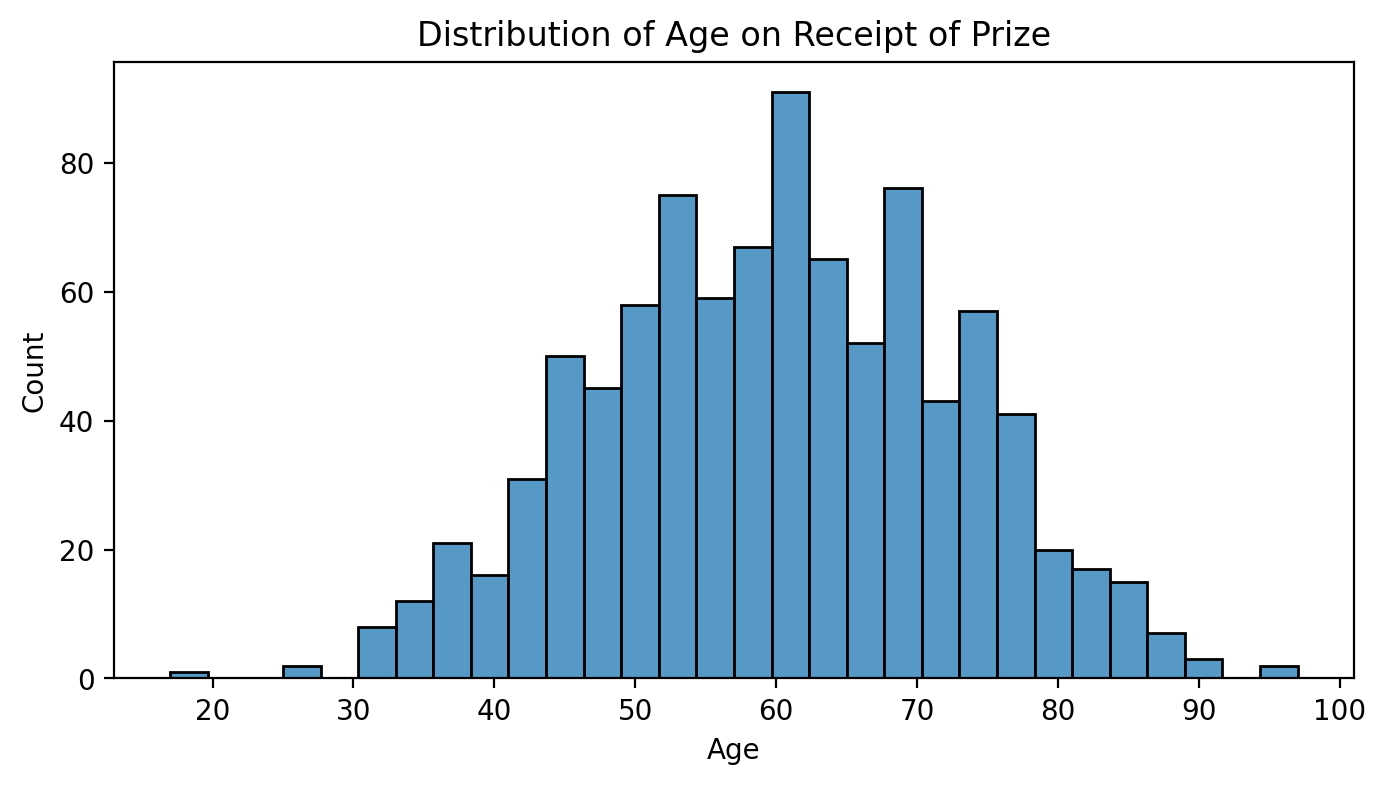

In [123]:
plt.figure(figsize=(8, 4), dpi=200)
sns.histplot(data=df_data,
             x=df_data.winning_age,
             bins=30)
plt.xlabel('Age')
plt.title('Distribution of Age on Receipt of Prize')
plt.show()

### Age at Time of Award throughout History


Are Nobel laureates being nominated later in life than before? Have the ages of laureates at the time of the award increased or decreased over time?

**Challenge**

* Use Seaborn to [create a .regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html?highlight=regplot#seaborn.regplot) with a trendline.
* Set the `lowess` parameter to `True` to show a moving average of the linear fit.
* According to the best fit line, how old were Nobel laureates in the years 1900-1940 when they were awarded the prize?
* According to the best fit line, what age would it predict for a Nobel laureate in 2020?

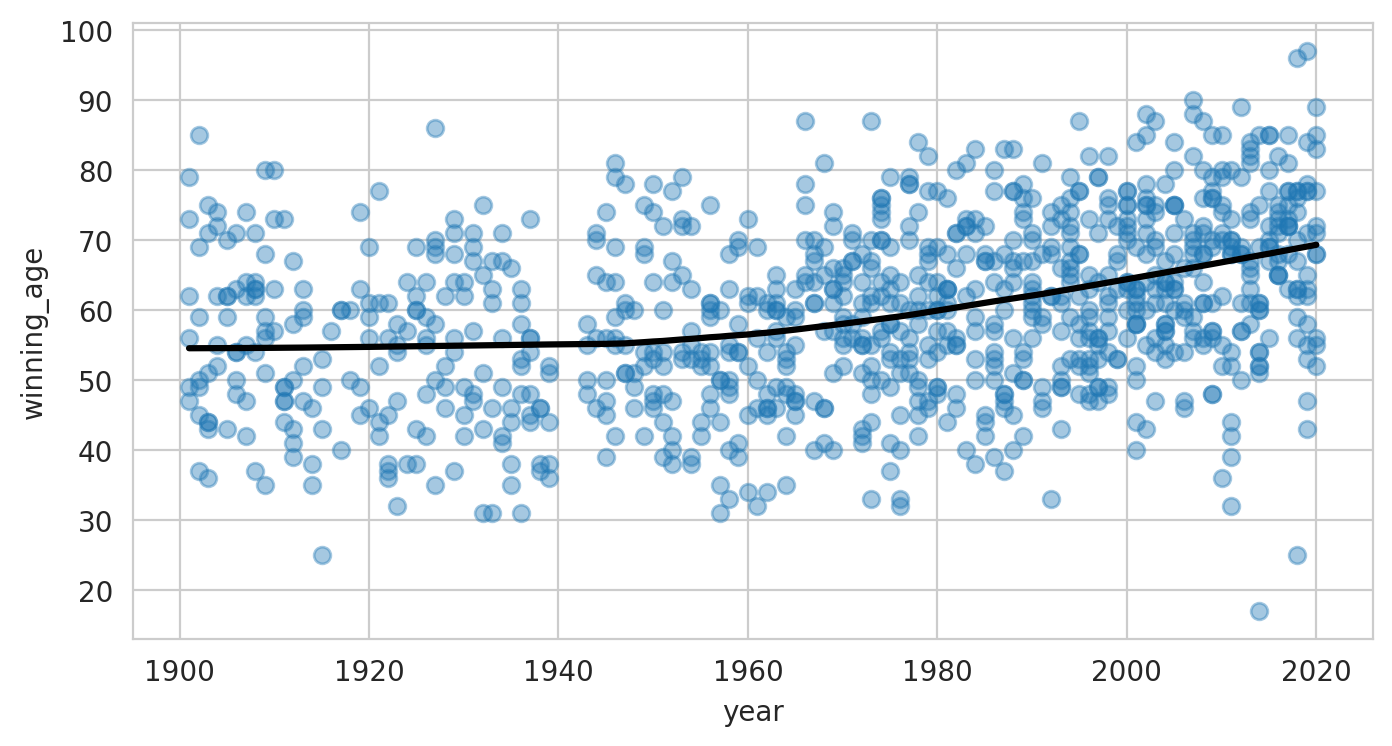

In [130]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
    sns.regplot(data=df_data,
                x='year',
                y='winning_age',
                lowess=True, 
                scatter_kws = {'alpha': 0.4},
                line_kws={'color': 'black'})
 
plt.show()

### Winning Age Across the Nobel Prize Categories

How does the age of laureates vary by category? 

* Use Seaborn's [`.boxplot()`](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot) to show how the mean, quartiles, max, and minimum values vary across categories. Which category has the longest "whiskers"? 
* In which prize category are the average winners the oldest?
* In which prize category are the average winners the youngest?

The box plot shows us the mean, the quartiles, the maximum and the minimum values. 

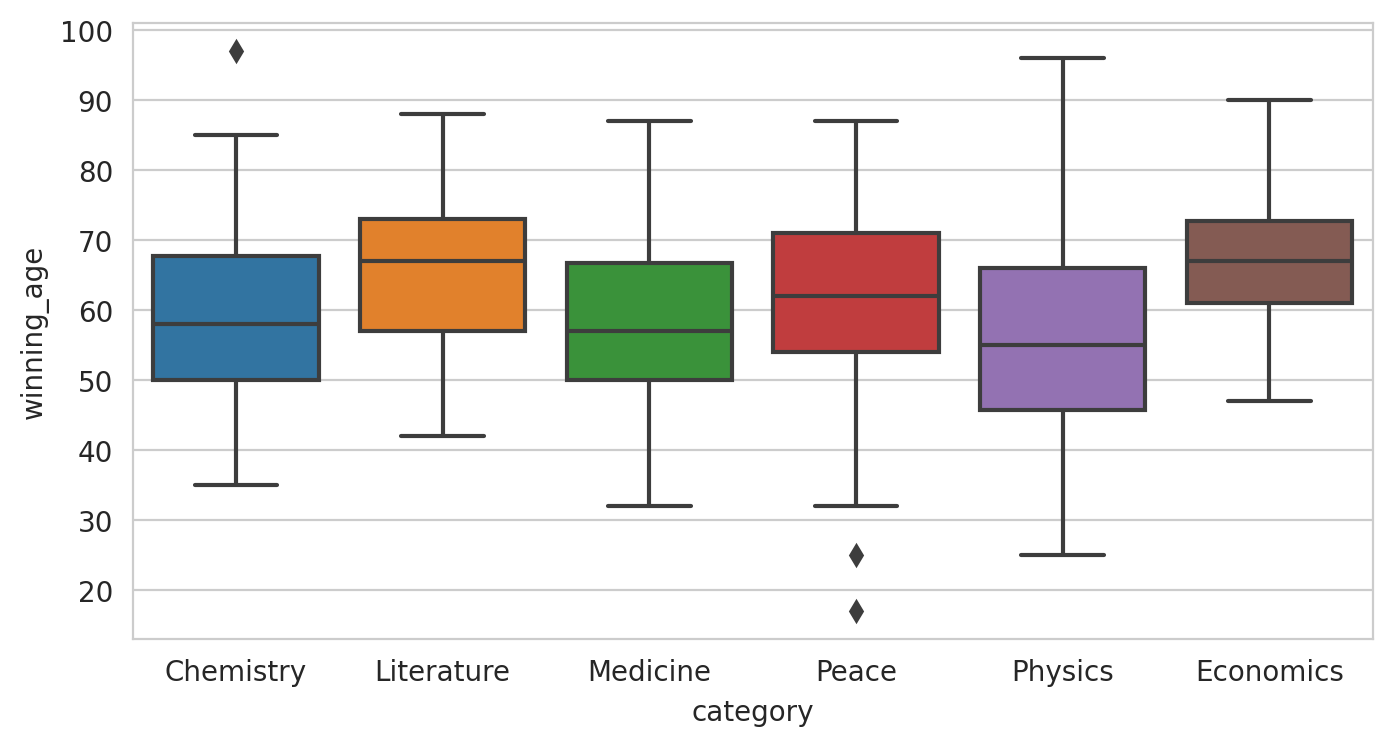

In [128]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
    sns.boxplot(data=df_data,
                x='category',
                y='winning_age')
 
plt.show()

### Challenge

* Now use Seaborn's [`.lmplot()`](https://seaborn.pydata.org/generated/seaborn.lmplot.html?highlight=lmplot#seaborn.lmplot) and the `row` parameter to create 6 separate charts for each prize category. Again set `lowess` to `True`.
* What are the winning age trends in each category? 
* Which category has the age trending up and which category has the age trending down? 
* Is this `.lmplot()` telling a different story from the `.boxplot()`?
* Create another chart with Seaborn. This time use `.lmplot()` to put all 6 categories on the same chart using the `hue` parameter. 

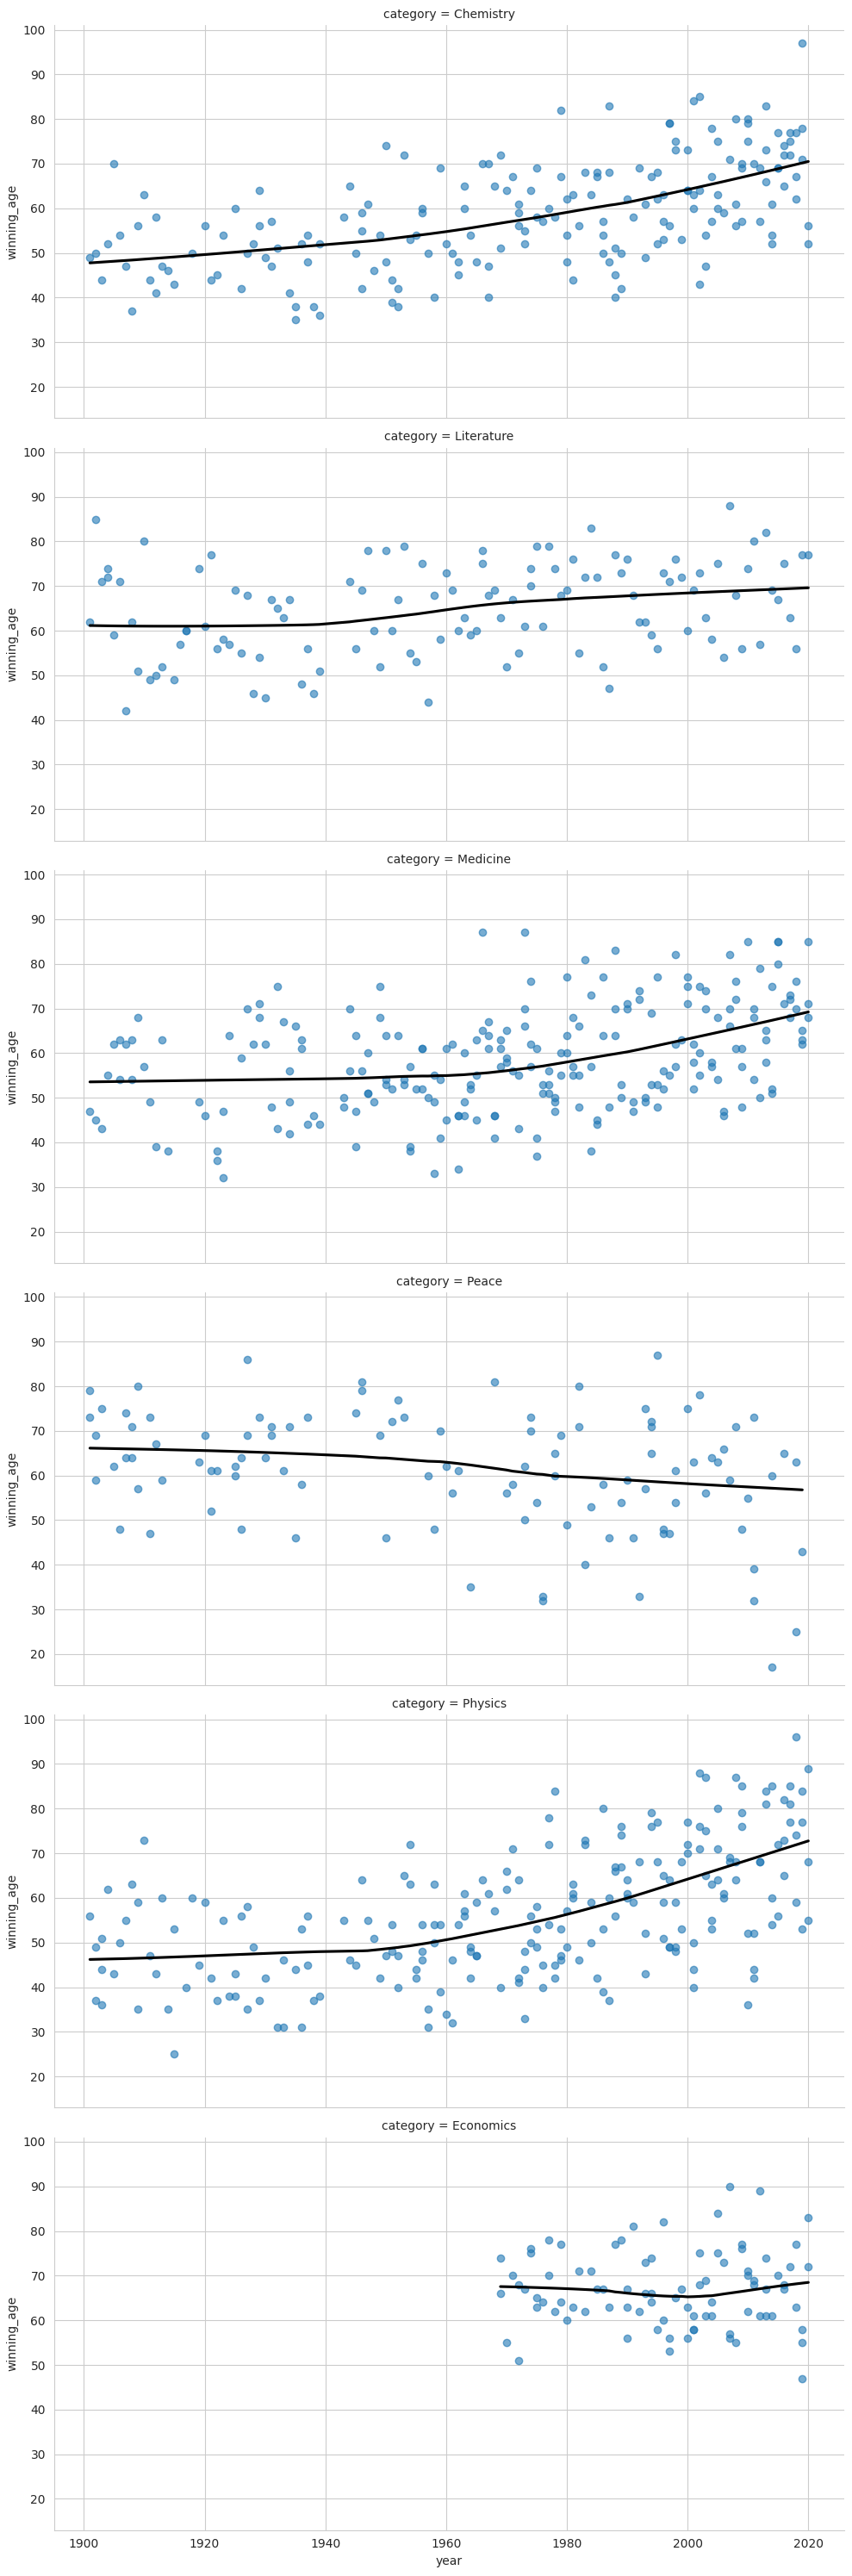

In [145]:
with sns.axes_style('whitegrid'):
    sns.lmplot(data=df_data,
               x='year', 
               y='winning_age',
               row = 'category',
               lowess=True, 
               aspect=2,
               scatter_kws = {'alpha': 0.6},
               line_kws = {'color': 'black'}
               )
plt.show()

To combine all these charts into the same chart, we can use the hue parameter

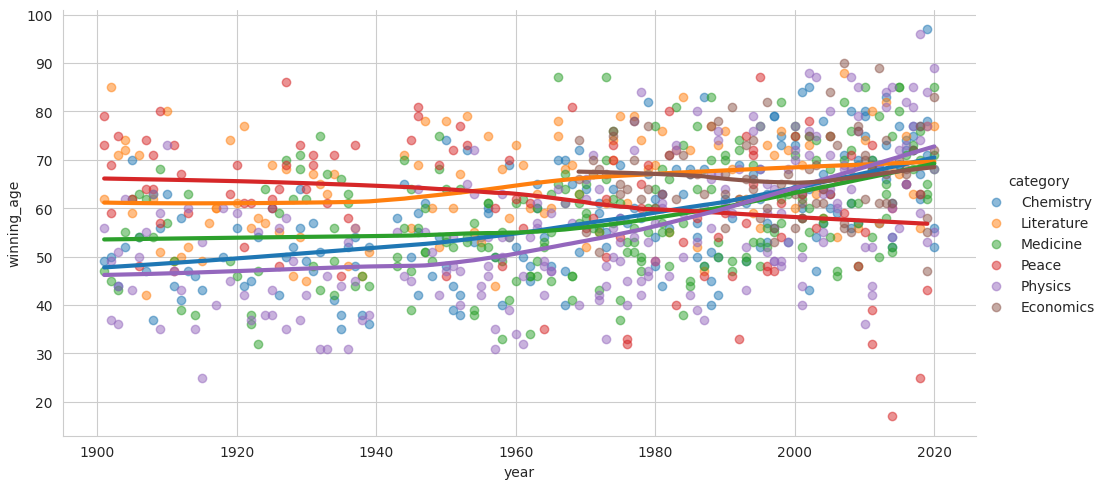

In [147]:
with sns.axes_style("whitegrid"):
    sns.lmplot(data=df_data,
               x='year',
               y='winning_age',
               hue='category',
               lowess=True, 
               aspect=2,
               scatter_kws={'alpha': 0.5},
               line_kws={'linewidth': 3})
 
plt.show()

## Learning Points & Summary

In this lesson, we reviewed many concepts that we've covered previously, including:

- How to uncover and investigate NaN values.

- How to convert objects and string data types to numbers.

- Creating donut and bar charts with plotly.

- Create a rolling average to smooth out time-series data and show a trend.

- How to use .value_counts(), .groupby(), .merge(), .sort_values() and .agg().